In [68]:
import sys
import subprocess
import os

def install_torch_cuda():
    print("🔄 Detected PyTorch CPU. Starting automatic installation of CUDA version...")
    
    # 1. Uninstall current packages
    packages = ["torch", "torchvision", "torchaudio"]
    print(f"   - Uninstalling {', '.join(packages)}...")
    subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y"] + packages)
    
    # 2. Install CUDA version (Target CUDA 12.x for driver 12.9)
    # Stable URL for PyTorch with CUDA
    cuda_url = "https://download.pytorch.org/whl/cu124" 
    print(f"   - Installing from {cuda_url}...")
    
    try:
        subprocess.check_call([
            sys.executable, "-m", "pip", "install", 
            "torch", "torchvision", "torchaudio", 
            "--index-url", cuda_url
        ])
        print("\n✅ Installation completed successfully!")
        print("⚠️ IMPORTANT: You must RESTART THE KERNEL now to load the new version.")
        print("   (In VS Code: click 'Restart' in the notebook toolbar)")
    except Exception as e:
        print(f"\n❌ Error during installation: {e}")

try:
    import torch
    print(f"Current PyTorch version: {torch.__version__}")
    
    if torch.cuda.is_available():
        print(f"✅ CUDA Detected and Working!")
        print(f"   GPU: {torch.cuda.get_device_name(0)}")
    else:
        print("⚠️ CUDA not available in current version.")
        if "cpu" in torch.__version__:
            install_torch_cuda()
except ImportError:
    print("❌ PyTorch not found.")
    install_torch_cuda(
    )

Current PyTorch version: 2.6.0+cu124
✅ CUDA Detected and Working!
   GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import os
import sys
import pickle

print("✓ Libraries imported")

# Global Device Configuration
# Check CUDA availability and print info
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"🚀 CUDA Available!")
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
    print(f"   Memory Cached: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
else:
    device = torch.device('cpu')
    print("⚠️ CUDA NOT available. Using CPU.")

print(f"PyTorch version: {torch.__version__}")
print(f"Active device: {device}")

✓ Libraries imported
🚀 CUDA Available!
   GPU: NVIDIA GeForce RTX 4060 Laptop GPU
   Memory Allocated: 170.25 MB
   Memory Cached: 890.00 MB
PyTorch version: 2.6.0+cu124
Active device: cuda


## 2. DATA LOADING

In [70]:
# ===== CONFIGURATION =====
# Select the appliance to disaggregate
# Available appliances:
# - chargingstation_socket, dishwasher, dryer, garagecabinet
# - heatpump, heatpump_controller, oven, rainwaterpump
# - rangehood, smappeecharger, stove, washingmachine

TARGET_APPLIANCE = 'heatpump'  # Change here to select another appliance

# Base data path
DATA_BASE_PATH = os.path.join("..", "data", "processed", "15min", "model_ready")
APPLIANCE_PATH = os.path.join(DATA_BASE_PATH, TARGET_APPLIANCE)

# List of available appliances
available_appliances = [d for d in os.listdir(DATA_BASE_PATH) 
                        if os.path.isdir(os.path.join(DATA_BASE_PATH, d))]
print(f"Available appliances: {available_appliances}")

# Verify that the selected appliance exists
assert TARGET_APPLIANCE in available_appliances, f"Appliance '{TARGET_APPLIANCE}' not found!"

# Carica i dati preprocessati
X_train = np.load(os.path.join(APPLIANCE_PATH, "X_train.npy"))
X_val = np.load(os.path.join(APPLIANCE_PATH, "X_val.npy"))
X_test = np.load(os.path.join(APPLIANCE_PATH, "X_test.npy"))
y_train = np.load(os.path.join(APPLIANCE_PATH, "y_train.npy"))
y_val = np.load(os.path.join(APPLIANCE_PATH, "y_val.npy"))
y_test = np.load(os.path.join(APPLIANCE_PATH, "y_test.npy"))

# ===== DATA CLEANING: THRESHOLD FOR NEAR-ZERO VALUES =====
ZERO_THRESHOLD = 0.001  # Values below this threshold become 0

# Count values before cleaning
before_train = np.sum((y_train > 0) & (y_train < ZERO_THRESHOLD))
before_val = np.sum((y_val > 0) & (y_val < ZERO_THRESHOLD))
before_test = np.sum((y_test > 0) & (y_test < ZERO_THRESHOLD))

# Apply threshold to targets (y)
y_train = np.where(y_train < ZERO_THRESHOLD, 0.0, y_train)
y_val = np.where(y_val < ZERO_THRESHOLD, 0.0, y_val)
y_test = np.where(y_test < ZERO_THRESHOLD, 0.0, y_test)

print(f"🧹 Cleaning near-zero values (threshold={ZERO_THRESHOLD}):")
print(f"   Train: {before_train:,} values → 0")
print(f"   Val:   {before_val:,} values → 0")
print(f"   Test:  {before_test:,} values → 0")

# Load scaler if available
scaler_path = os.path.join(DATA_BASE_PATH, "scaler.pkl")
if os.path.exists(scaler_path):
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    print(f"✓ Scaler loaded from {scaler_path}")
else:
    scaler = None
    print("⚠️ Scaler not found, data might already be normalized")

print(f"\n✓ Dataset '{TARGET_APPLIANCE}' loaded:")
print(f"  X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape} | y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape} | y_test:  {y_test.shape}")

# Determina parametri dai dati
# X shape: (samples, seq_len, num_features)
# y shape: (samples, seq_len, 1)
window_size = X_train.shape[1]  # 99 timesteps
num_input_features = X_train.shape[2]  # 7 features

print(f"\n✓ Window size: {window_size} timesteps")
print(f"✓ Input features: {num_input_features}")

Available appliances: ['chargingstation_socket', 'dishwasher', 'dryer', 'garagecabinet', 'heatpump', 'heatpump_controller', 'oven', 'rainwaterpump', 'rangehood', 'smappeecharger', 'stove', 'washingmachine']
🧹 Cleaning near-zero values (threshold=0.001):
   Train: 1,708,757 values → 0
   Val:   363,509 values → 0
   Test:  370,000 values → 0
⚠️ Scaler not found, data might already be normalized

✓ Dataset 'heatpump' loaded:
  X_train: (24097, 96, 7) | y_train: (24097, 96, 1)
  X_val:   (5377, 96, 7) | y_val:   (5377, 96, 1)
  X_test:  (5281, 96, 7) | y_test:  (5281, 96, 1)

✓ Window size: 96 timesteps
✓ Input features: 7


## 3. EXPLORATORY DATA ANALYSIS

In [71]:
# Analyze loaded data
print("=== DATASET STATISTICS ===")
print(f"\n📊 Input (X) - {num_input_features} features:")
print(f"  Train: min={X_train.min():.4f}, max={X_train.max():.4f}, mean={X_train.mean():.4f}")
print(f"  Val:   min={X_val.min():.4f}, max={X_val.max():.4f}, mean={X_val.mean():.4f}")
print(f"  Test:  min={X_test.min():.4f}, max={X_test.max():.4f}, mean={X_test.mean():.4f}")

print(f"\n📊 Statistics per feature (X_train):")
for i in range(num_input_features):
    feat_data = X_train[:, :, i]
    print(f"  Feature {i}: min={feat_data.min():.4f}, max={feat_data.max():.4f}, mean={feat_data.mean():.4f}")

print(f"\n📊 Target (y - {TARGET_APPLIANCE}):")
print(f"  Train: min={y_train.min():.4f}, max={y_train.max():.4f}, mean={y_train.mean():.4f}")
print(f"  Val:   min={y_val.min():.4f}, max={y_val.max():.4f}, mean={y_val.mean():.4f}")
print(f"  Test:  min={y_test.min():.4f}, max={y_test.max():.4f}, mean={y_test.mean():.4f}")

print(f"\n📊 Dimensions:")
print(f"  Total sequences: {len(X_train) + len(X_val) + len(X_test)}")
print(f"  Train: {len(X_train)} ({len(X_train)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")
print(f"  Val:   {len(X_val)} ({len(X_val)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")
print(f"  Test:  {len(X_test)} ({len(X_test)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")

=== DATASET STATISTICS ===

📊 Input (X) - 7 features:
  Train: min=0.0000, max=1.0000, mean=0.4376
  Val:   min=0.0000, max=1.0000, mean=0.4454
  Test:  min=0.0000, max=1.0000, mean=0.4467

📊 Statistics per feature (X_train):
  Feature 0: min=0.0000, max=1.0000, mean=0.1040
  Feature 1: min=0.0000, max=1.0000, mean=0.5000
  Feature 2: min=0.0000, max=1.0000, mean=0.5000
  Feature 3: min=0.0000, max=1.0000, mean=0.5017
  Feature 4: min=0.0000, max=1.0000, mean=0.4734
  Feature 5: min=0.0000, max=1.0000, mean=0.4841
  Feature 6: min=0.0000, max=1.0000, mean=0.4999

📊 Target (y - heatpump):
  Train: min=0.0000, max=1.0000, mean=0.1147
  Val:   min=0.0000, max=0.9938, mean=0.1371
  Test:  min=0.0000, max=0.9986, mean=0.1372

📊 Dimensions:
  Total sequences: 34755
  Train: 24097 (69.3%)
  Val:   5377 (15.5%)
  Test:  5281 (15.2%)


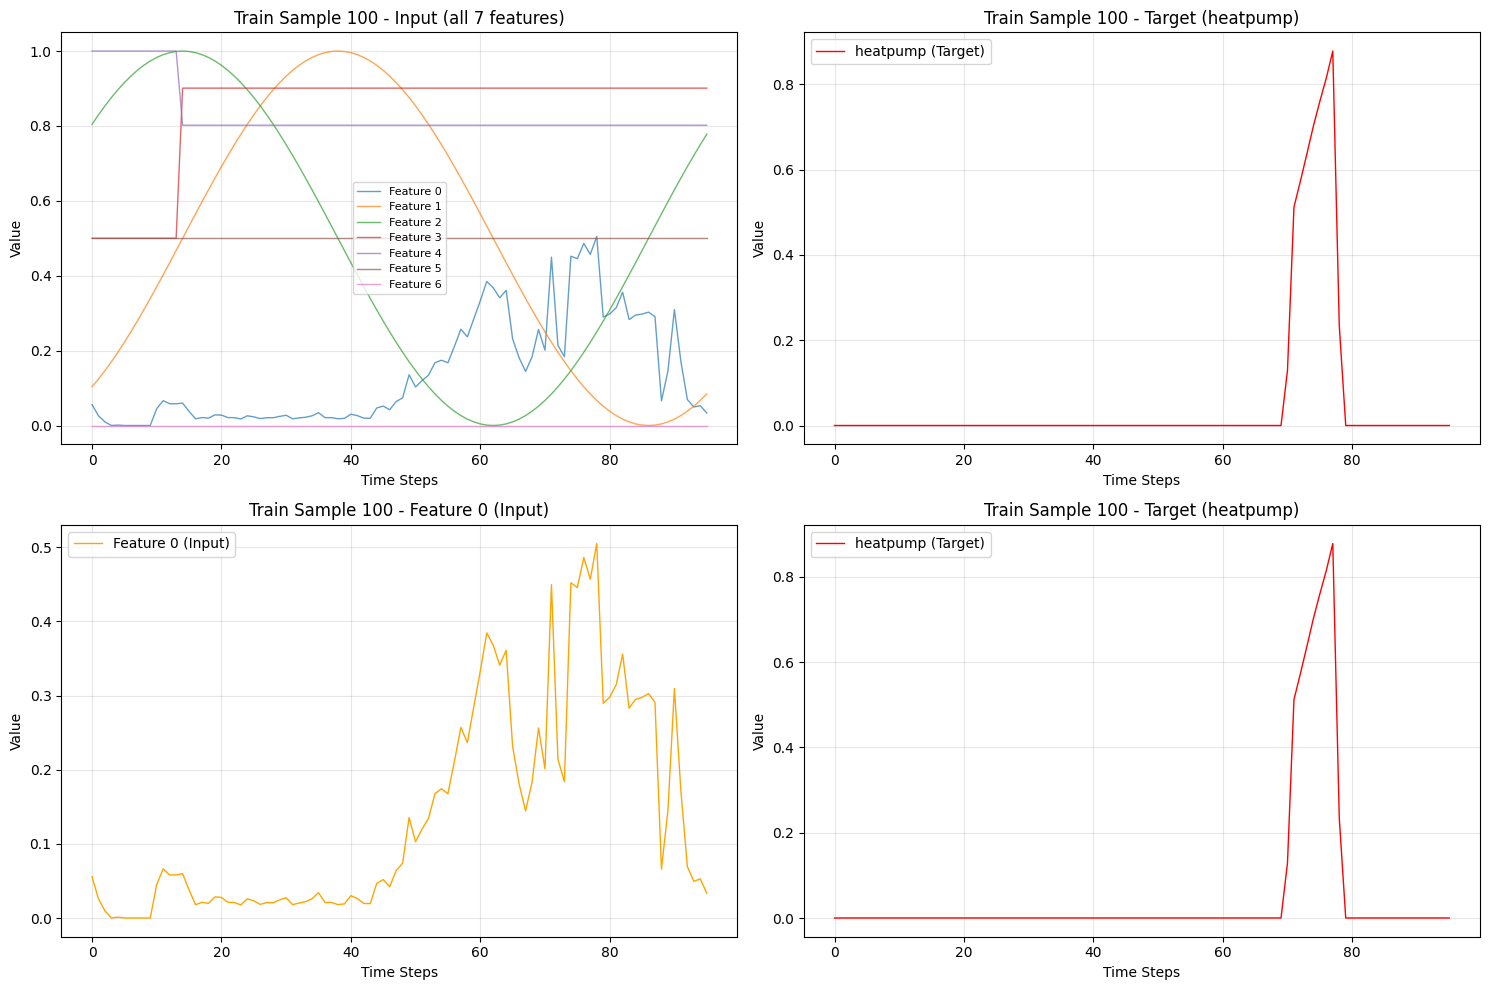

In [72]:
# Visualizza alcune sequenze di esempio
sample_idx = 100

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot all input features for first sample
ax = axes[0, 0]
for i in range(num_input_features):
    ax.plot(X_train[sample_idx, :, i], linewidth=1, label=f'Feature {i}', alpha=0.7)
ax.set_title(f'Train Sample {sample_idx} - Input (all {num_input_features} features)')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Value')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

# Target per il primo sample
ax = axes[0, 1]
ax.plot(y_train[sample_idx, :, 0], linewidth=1, color='red', label=f'{TARGET_APPLIANCE} (Target)')
ax.set_title(f'Train Sample {sample_idx} - Target ({TARGET_APPLIANCE})')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Value')
ax.grid(True, alpha=0.3)
ax.legend()

# Second sequence - only feature 0 (assuming it's the main aggregate)
sample_idx_2 = min(100, len(X_train)-1)
ax = axes[1, 0]
ax.plot(X_train[sample_idx_2, :, 0], linewidth=1, color='orange', label='Feature 0 (Input)')
ax.set_title(f'Train Sample {sample_idx_2} - Feature 0 (Input)')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Value')
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[1, 1]
ax.plot(y_train[sample_idx_2, :, 0], linewidth=1, color='red', label=f'{TARGET_APPLIANCE} (Target)')
ax.set_title(f'Train Sample {sample_idx_2} - Target ({TARGET_APPLIANCE})')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Value')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## 4. DATA NORMALIZATION & SEQUENCE CREATION

In [73]:
# Data is already preprocessed and ready for training
# Shape: X -> (samples, seq_len, num_features), y -> (samples, seq_len, 1)

print(f"✓ Data ready for training")
print(f"  X_train shape: {X_train.shape} -> (samples, seq_len={window_size}, features={num_input_features})")
print(f"  y_train shape: {y_train.shape} -> (samples, seq_len={window_size}, target=1)")
print(f"  X_val shape: {X_val.shape}")
print(f"  y_val shape: {y_val.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")

✓ Data ready for training
  X_train shape: (24097, 96, 7) -> (samples, seq_len=96, features=7)
  y_train shape: (24097, 96, 1) -> (samples, seq_len=96, target=1)
  X_val shape: (5377, 96, 7)
  y_val shape: (5377, 96, 1)
  X_test shape: (5281, 96, 7)
  y_test shape: (5281, 96, 1)


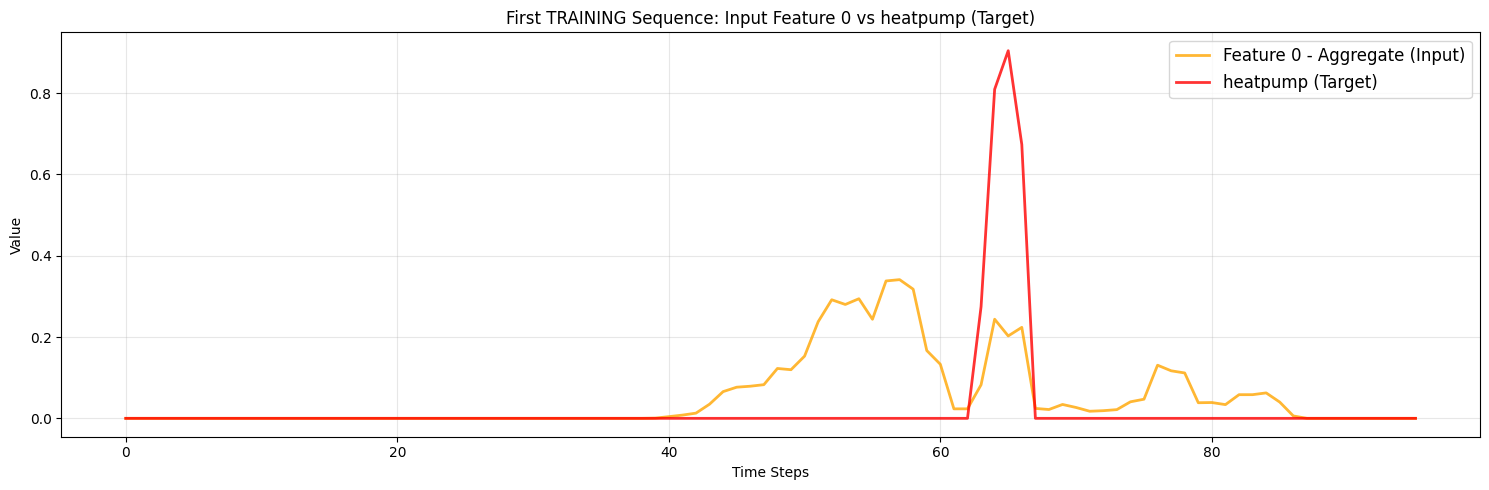

In [74]:
# Visualize Input vs Target comparison for first TRAINING sequence
plt.figure(figsize=(15, 5))
# Plot feature 0 (assuming it's the aggregate/total consumption)
plt.plot(range(window_size), X_train[0, :, 0], linewidth=2, color='orange', label='Feature 0 - Aggregate (Input)', alpha=0.8)
plt.plot(range(window_size), y_train[0, :, 0], linewidth=2, color='red', label=f'{TARGET_APPLIANCE} (Target)', alpha=0.8)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title(f'First TRAINING Sequence: Input Feature 0 vs {TARGET_APPLIANCE} (Target)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. MODEL DEFINITION - CNN Seq2Seq

In [75]:
import torch
import torch.nn as nn

class SimpleAttention(nn.Module):
    def __init__(self, feature_dim):
        super(SimpleAttention, self).__init__()
        # feature_dim must match the channels at that point (e.g., 192 or 384)
        self.attn = nn.MultiheadAttention(embed_dim=feature_dim, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(feature_dim)

    def forward(self, x):
        # x shape: (Batch, Channels, Length) -> transform for attention
        x = x.transpose(1, 2) # Becomes (Batch, Length, Channels)
        
        # Self-attention: query, key e value sono lo stesso input
        attn_output, _ = self.attn(x, x, x)
        
        # Residual connection and Normalization
        x = self.norm(x + attn_output)
        
        return x.transpose(1, 2) # Back to (Batch, Channels, Length)

In [76]:
import torch
import torch.nn as nn

class CNNSeq2Seq(nn.Module):
    """
    CNN Encoder-Decoder for NILM with multi-feature support
    and temporal attention on bottleneck.

    This version can optionally augment the input with a simple
    frequency-domain summary (FFT magnitude mean per feature)
    concatenated to the original time-domain features.
    """
    def __init__(self, input_channels=7, hidden_channels=48, num_layers=3, fft_augment=True):
        super().__init__()

        self.input_channels = input_channels
        self.fft_augment = fft_augment
        fft_multiplier = 2 if fft_augment else 1

        # Effective input channels after optional FFT augmentation
        effective_in_ch = input_channels * fft_multiplier

        # ---------- ENCODER ----------
        encoder_layers = []
        in_ch = effective_in_ch

        for i in range(num_layers):
            out_ch = hidden_channels * (2 ** i)
            encoder_layers += [
                nn.Conv1d(in_ch, out_ch, kernel_size=5, padding=2),
                nn.BatchNorm1d(out_ch),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.4)
            ]
            in_ch = out_ch

        self.encoder = nn.Sequential(*encoder_layers)

        # Bottleneck channels
        self.bottleneck_ch = hidden_channels * (2 ** (num_layers - 1))

        # ---------- ATTENTION ----------
        self.attention = SimpleAttention(self.bottleneck_ch)

        self.lstm = nn.LSTM(input_size=self.bottleneck_ch, hidden_size=self.bottleneck_ch,
                            num_layers=3, batch_first=True, dropout=0.5)

        # ---------- DECODER ----------
        decoder_layers = []
        in_ch = self.bottleneck_ch

        for i in reversed(range(num_layers)):
            out_ch = hidden_channels * (2 ** i) if i > 0 else hidden_channels
            decoder_layers += [
                nn.Conv1d(in_ch, out_ch, kernel_size=5, padding=2),
                nn.BatchNorm1d(out_ch),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.4)
            ]
            in_ch = out_ch

        self.decoder = nn.Sequential(*decoder_layers)
        
        # Additional pre-output dropout
        self.final_dropout = nn.Dropout(0.4)

        # ---------- OUTPUT HEADS ----------
        # Head 1: Power prediction (regression)
        self.power_head = nn.Sequential(
            nn.Conv1d(hidden_channels, 1, kernel_size=1),
            nn.ReLU()
        )
        
        # Head 2: Status prediction (ON/OFF classification)
        self.status_head = nn.Conv1d(hidden_channels, 1, kernel_size=1)  # No activation, BCEWithLogitsLoss

    def forward(self, x):
        # x: (B, T, F)  - time-domain features
        # Optionally augment with a simple FFT magnitude summary per feature
        if self.fft_augment:
            # Compute rFFT along time axis -> (B, Tfreq, F)
            fft_mag = torch.abs(torch.fft.rfft(x, dim=1))
            # Summary statistic across frequency bins -> (B, F)
            freq_feat = fft_mag.mean(dim=1)
            # Expand to time dimension and concatenate -> (B, T, F)
            freq_feat_exp = freq_feat.unsqueeze(1).expand(-1, x.size(1), -1)
            x = torch.cat([x, freq_feat_exp], dim=2)

        # x now: (B, T, F') where F' = F or 2*F
        x = x.transpose(1, 2)  # -> (B, F', T)

        encoded = self.encoder(x)

        encoded = encoded.transpose(1, 2)  # (B, T, C)

        # Temporal attention via LSTM
        encoded, _ = self.lstm(encoded)

        encoded = encoded.transpose(1, 2)  # (B, C, T)

        encoded = self.attention(encoded)

        decoded = self.decoder(encoded)
        
        # Final dropout to reduce overfitting
        decoded = self.final_dropout(decoded)

        # Dual outputs
        power_out = self.power_head(decoded)    # (B, 1, T)
        status_out = self.status_head(decoded)  # (B, 1, T)

        # (B, 1, T) → (B, T, 1)
        return power_out.transpose(1, 2), status_out.transpose(1, 2)


print("✓ CNN Seq2Seq Model defined (with optional FFT augmentation)")
print("  - Base input channels: configured at instantiation")
print("  - Encoder-Decoder architecture with LSTM")
print("  - Dual output: Power (ReLU) + Status (logits)")

✓ CNN Seq2Seq Model defined (with optional FFT augmentation)
  - Base input channels: configured at instantiation
  - Encoder-Decoder architecture with LSTM
  - Dual output: Power (ReLU) + Status (logits)


## 6. DATA PREPARATION FOR TRAINING

In [77]:
class EnergyDataset(Dataset):
    def __init__(self, X, y, device=None, augment=False, noise_std=0.01):
        # Convert to tensor
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        
        # Move to GPU (device) if specified - optimization for small/medium datasets
        if device is not None:
            self.X = self.X.to(device)
            self.y = self.y.to(device)
            print(f"Dataset loaded on {device}")
            
        self.device = device
        self.augment = augment
        self.noise_std = noise_std
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        if self.augment and self.noise_std > 0:
            # Generate noise on the same device as the data
            noise = torch.randn_like(x) * self.noise_std
            x = torch.clamp(x + noise, 0.0, 1.0)
        return x, self.y[idx]

print("✓ EnergyDataset defined (GPU transfer support)")

✓ EnergyDataset defined (GPU transfer support)


## 7. HYPERPARAMETER TUNING

Automatic search for the best hyperparameters using Optuna and validation loss.

# ===== HYPERPARAMETER TUNING WITH OPTUNA =====
import optuna
from optuna.trial import TrialState
import gc

# Number of tuning trials
N_TRIALS = 20
TUNING_EPOCHS = 30  # Fewer epochs per trial for speed

def objective(trial):
    """Objective function for Optuna hyperparameter optimization"""
    
    # Hyperparameters to tune
    hidden_channels = trial.suggest_categorical('hidden_channels', [32, 48, 64, 96])
    num_layers = trial.suggest_int('num_layers', 2, 4)
    dropout_encoder = trial.suggest_float('dropout_encoder', 0.2, 0.6, step=0.1)
    dropout_decoder = trial.suggest_float('dropout_decoder', 0.2, 0.5, step=0.1)
    lstm_layers = trial.suggest_int('lstm_layers', 1, 3)
    lstm_dropout = trial.suggest_float('lstm_dropout', 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    noise_std = trial.suggest_float('noise_std', 0.0, 0.15, step=0.025)
    peak_weight = trial.suggest_float('peak_weight', 5.0, 100.0, step=5.0)
    
    # Create model with trial hyperparameters
    class TrialCNNSeq2Seq(nn.Module):
        def __init__(self):
            super().__init__()
            encoder_layers = []
            in_ch = num_input_features
            for i in range(num_layers):
                out_ch = hidden_channels * (2 ** i)
                encoder_layers += [
                    nn.Conv1d(in_ch, out_ch, kernel_size=5, padding=2),
                    nn.BatchNorm1d(out_ch),
                    nn.LeakyReLU(),
                    nn.Dropout(dropout_encoder)
                ]
                in_ch = out_ch
            self.encoder = nn.Sequential(*encoder_layers)
            
            bottleneck_ch = hidden_channels * (2 ** (num_layers - 1))
            self.lstm = nn.LSTM(input_size=bottleneck_ch, hidden_size=bottleneck_ch,
                               num_layers=lstm_layers, batch_first=True, 
                               dropout=lstm_dropout if lstm_layers > 1 else 0)
            
            decoder_layers = []
            in_ch = bottleneck_ch
            for i in reversed(range(num_layers)):
                out_ch = hidden_channels * (2 ** i) if i > 0 else hidden_channels
                decoder_layers += [
                    nn.Conv1d(in_ch, out_ch, kernel_size=5, padding=2),
                    nn.BatchNorm1d(out_ch),
                    nn.LeakyReLU(),
                    nn.Dropout(dropout_decoder)
                ]
                in_ch = out_ch
            self.decoder = nn.Sequential(*decoder_layers)
            self.final_dropout = nn.Dropout(dropout_decoder)
            self.power_head = nn.Sequential(nn.Conv1d(hidden_channels, 1, kernel_size=1), nn.ReLU())
            self.status_head = nn.Conv1d(hidden_channels, 1, kernel_size=1)

        def forward(self, x):
            x = x.transpose(1, 2)
            encoded = self.encoder(x)
            encoded = encoded.transpose(1, 2)
            encoded, _ = self.lstm(encoded)
            encoded = encoded.transpose(1, 2)
            decoded = self.decoder(encoded)
            decoded = self.final_dropout(decoded)
            power_out = self.power_head(decoded)
            status_out = self.status_head(decoded)
            return power_out.transpose(1, 2), status_out.transpose(1, 2)
    
    # Create datasets with trial batch size and noise
    trial_train_dataset = EnergyDataset(X_train, y_train, device=device, augment=True, noise_std=noise_std)
    trial_val_dataset = EnergyDataset(X_val, y_val, device=device, augment=False)
    trial_train_loader = DataLoader(trial_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    trial_val_loader = DataLoader(trial_val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Create model and optimizer
    trial_model = TrialCNNSeq2Seq().to(device)
    
    # Loss with trial peak_weight
    class TrialNILMLoss(nn.Module):
        def __init__(self):
            super().__init__()
            self.gamma = 2.0
            self.peak_weight = peak_weight
        def forward(self, pred, target):
            mse = (pred - target) ** 2
            focal_weight = (target ** self.gamma) * self.peak_weight + 1.0
            weighted_mse = (mse * focal_weight).mean()
            under_pred = torch.clamp(target - pred, min=0)
            under_pred_penalty = (under_pred ** 2 * focal_weight).mean()
            return weighted_mse + under_pred_penalty
    
    class TrialMultiTaskLoss(nn.Module):
        def __init__(self):
            super().__init__()
            self.reg_loss = TrialNILMLoss()
            self.bce_loss = nn.BCEWithLogitsLoss()
        def forward(self, pred_power, pred_status, target_power, target_status):
            return self.reg_loss(pred_power, target_power) + 0.5 * self.bce_loss(pred_status, target_status)
    
    trial_criterion = TrialMultiTaskLoss()
    trial_optimizer = optim.AdamW(trial_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(TUNING_EPOCHS):
        # Train
        trial_model.train()
        for inp, tgt in trial_train_loader:
            tgt_status = (tgt > 0.001).float()
            trial_optimizer.zero_grad()
            pred_power, pred_status = trial_model(inp)
            loss = trial_criterion(pred_power, pred_status, tgt, tgt_status)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(trial_model.parameters(), 1.0)
            trial_optimizer.step()
        
        # Validate
        trial_model.eval()
        val_loss = 0
        with torch.no_grad():
            for inp, tgt in trial_val_loader:
                tgt_status = (tgt > 0.001).float()
                pred_power, pred_status = trial_model(inp)
                val_loss += trial_criterion(pred_power, pred_status, tgt, tgt_status).item()
        val_loss /= len(trial_val_loader)
        
        # Report intermediate value for pruning
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 5:
                break
    
    # Cleanup
    del trial_model, trial_optimizer, trial_train_loader, trial_val_loader
    gc.collect()
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    return best_val_loss

# Run hyperparameter search
print(f"🔍 Starting Hyperparameter Tuning ({N_TRIALS} trials, {TUNING_EPOCHS} epochs each)...")
print(f"   This may take a while...\n")

study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

# Print results
print("\n" + "="*80)
print("🏆 HYPERPARAMETER TUNING RESULTS")
print("="*80)

print(f"\n📊 Best Trial: #{study.best_trial.number}")
print(f"   Best Validation Loss: {study.best_trial.value:.6f}")

print(f"\n🎯 Best Hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"   {key}: {value}")

# Store best params for later use
BEST_PARAMS = study.best_trial.params
print("\n✓ Best parameters saved to BEST_PARAMS dictionary")

# ===== VISUALIZE TUNING RESULTS =====
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Optimization History
ax = axes[0, 0]
trials_df = study.trials_dataframe()
completed = trials_df[trials_df['state'] == 'COMPLETE']
ax.plot(completed.index, completed['value'], 'bo-', alpha=0.7, label='Completed trials')
ax.axhline(y=study.best_value, color='red', linestyle='--', label=f'Best: {study.best_value:.4f}')
ax.set_xlabel('Trial')
ax.set_ylabel('Validation Loss')
ax.set_title('Optimization History')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Parameter Importance (if enough trials)
ax = axes[0, 1]
try:
    importances = optuna.importance.get_param_importances(study)
    params = list(importances.keys())[:10]
    values = [importances[p] for p in params]
    ax.barh(params, values, color='steelblue', alpha=0.7)
    ax.set_xlabel('Importance')
    ax.set_title('Hyperparameter Importance')
except:
    ax.text(0.5, 0.5, 'Not enough trials\nfor importance analysis', 
            ha='center', va='center', fontsize=12)
    ax.set_title('Hyperparameter Importance')

# Plot 3: hidden_channels vs loss
ax = axes[1, 0]
if 'params_hidden_channels' in completed.columns:
    ax.scatter(completed['params_hidden_channels'], completed['value'], alpha=0.7, c='green')
    ax.set_xlabel('Hidden Channels')
    ax.set_ylabel('Validation Loss')
    ax.set_title('Hidden Channels vs Loss')
    ax.grid(True, alpha=0.3)

# Plot 4: learning_rate vs loss
ax = axes[1, 1]
if 'params_learning_rate' in completed.columns:
    ax.scatter(completed['params_learning_rate'], completed['value'], alpha=0.7, c='purple')
    ax.set_xscale('log')
    ax.set_xlabel('Learning Rate (log scale)')
    ax.set_ylabel('Validation Loss')
    ax.set_title('Learning Rate vs Loss')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📋 Top 5 Trials:")
print(completed.nsmallest(5, 'value')[['number', 'value', 'params_hidden_channels', 
                                        'params_learning_rate', 'params_dropout_encoder']].to_string())

## 8. TRAINING WITH BEST HYPERPARAMETERS

Training with the best hyperparameters found during tuning.

In [78]:
# ===== CONFIGURATION AND TRAINING =====
# 🎯 USING BEST HYPERPARAMETERS FROM TUNING (or defaults if tuning was skipped)

try:
    # Use tuned parameters if available
    batch_size = BEST_PARAMS.get('batch_size', 128)
    hidden_channels = BEST_PARAMS.get('hidden_channels', 64)
    num_layers = BEST_PARAMS.get('num_layers', 3)
    learning_rate = BEST_PARAMS.get('learning_rate', 0.0005)
    noise_std = BEST_PARAMS.get('noise_std', 0.1)
    weight_decay = BEST_PARAMS.get('weight_decay', 1e-2)
    peak_weight = BEST_PARAMS.get('peak_weight', 50.0)
    print("✓ Using TUNED hyperparameters!")
except NameError:
    # Fallback to manual defaults
    batch_size = 128
    hidden_channels = 64
    num_layers = 3
    learning_rate = 0.0005
    noise_std = 0.1
    weight_decay = 1e-2
    peak_weight = 50.0
    print("⚠️ BEST_PARAMS not found - using default hyperparameters")

peak_weight = 50
num_epochs = 200

# Print configuration
print(f"\n📋 Training Configuration:")
print(f"   hidden_channels: {hidden_channels}")
print(f"   num_layers: {num_layers}")
print(f"   learning_rate: {learning_rate}")
print(f"   weight_decay: {weight_decay}")
print(f"   batch_size: {batch_size}")
print(f"   noise_std: {noise_std}")
print(f"   peak_weight: {peak_weight}")

# Dataset
# Pass 'device' to pre-load data on GPU and speed up training
train_dataset = EnergyDataset(X_train, y_train, device=device, augment=True, noise_std=noise_std)
val_dataset = EnergyDataset(X_val, y_val, device=device, augment=False)
test_dataset = EnergyDataset(X_test, y_test, device=device, augment=False)

# If data is already on GPU, num_workers=0 is ideal and pin_memory is not needed
use_pin_memory = (device.type == 'cpu')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=use_pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=use_pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=use_pin_memory)

print(f"TRAINING Sequences: {len(X_train):,}")
print(f"VALIDATION Sequences: {len(X_val):,}")
print(f"TEST Sequences: {len(X_test):,}")
print(f"Device: {device}")
print(f"Noise std (train only): {noise_std}")

# Setup CNN Seq2Seq model
# device is already defined globally
model = CNNSeq2Seq(input_channels=num_input_features, hidden_channels=hidden_channels, num_layers=num_layers).to(device)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Input channels: {num_input_features}")

# === LOSS FUNCTION ===
class NILMLoss(nn.Module):
    """
    Loss for NILM with focus on peaks.
    """
    def __init__(self, gamma=2.0, peak_weight=10.0):
        super(NILMLoss, self).__init__()
        self.gamma = gamma
        self.peak_weight = peak_weight
        
    def forward(self, pred, target):
        # Base MSE
        mse = (pred - target) ** 2
        
        # Focal weighting: weight more the errors where target is high
        focal_weight = (target ** self.gamma) * self.peak_weight + 1.0
        
        # Weighted loss
        weighted_mse = (mse * focal_weight).mean()
        
        # Penalty for under-predictions (when target > pred)
        under_pred = torch.clamp(target - pred, min=0)
        under_pred_penalty = (under_pred ** 2 * focal_weight).mean()
        
        return weighted_mse + under_pred_penalty

class MultiTaskNILMLoss(nn.Module):
    def __init__(self, reg_weight=1.0, cls_weight=0.5, peak_wt=50.0):
        super().__init__()
        self.reg_loss = NILMLoss(gamma=2.0, peak_weight=peak_wt)  # Use tuned peak_weight
        self.bce_loss = nn.BCEWithLogitsLoss() # For ON/OFF
        self.reg_weight = reg_weight
        self.cls_weight = cls_weight

    def forward(self, pred_power, pred_status, target_power, target_status):
        l_reg = self.reg_loss(pred_power, target_power)
        l_cls = self.bce_loss(pred_status, target_status)
        return (self.reg_weight * l_reg) + (self.cls_weight * l_cls)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Use tuned weight_decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
criterion = MultiTaskNILMLoss(reg_weight=1.0, cls_weight=0.5, peak_wt=peak_weight)  # Use tuned peak_weight

print("✓ NILMLoss configured (focal-style for peaks)")
print("✓ ReduceLROnPlateau scheduler active")

⚠️ BEST_PARAMS not found - using default hyperparameters

📋 Training Configuration:
   hidden_channels: 64
   num_layers: 3
   learning_rate: 0.0005
   weight_decay: 0.01
   batch_size: 128
   noise_std: 0.1
   peak_weight: 50
Dataset loaded on cuda
Dataset loaded on cuda
Dataset loaded on cuda
TRAINING Sequences: 24,097
VALIDATION Sequences: 5,377
TEST Sequences: 5,281
Device: cuda
Noise std (train only): 0.1
Parameters: 2,587,266
Input channels: 7
✓ NILMLoss configured (focal-style for peaks)
✓ ReduceLROnPlateau scheduler active


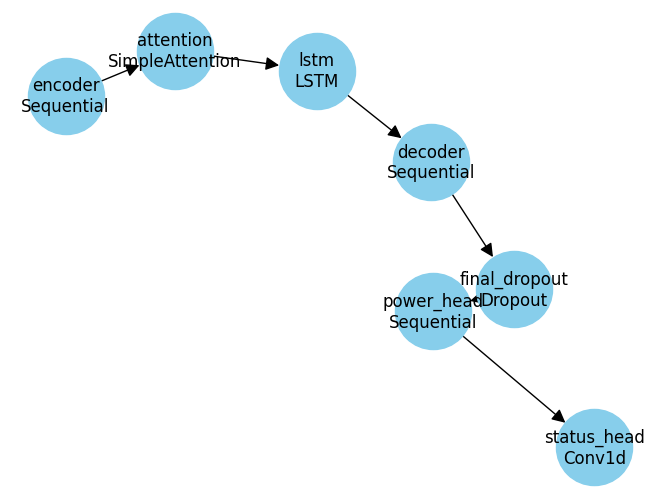

In [ ]:
# ===== MODEL ARCHITECTURE VISUALIZATION =====
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np

def draw_architecture(model, input_features=7, seq_len=99):
    """Visualize CNN Seq2Seq architecture with FFT augmentation"""
    
    fig, ax = plt.subplots(figsize=(18, 12))
    ax.set_xlim(0, 18)
    ax.set_ylim(0, 12)
    ax.axis('off')
    
    # Colors
    colors = {
        'input': '#3498db',
        'fft': '#9b59b6',
        'encoder': '#e74c3c',
        'lstm': '#f39c12',
        'attention': '#1abc9c',
        'decoder': '#2ecc71',
        'output': '#e91e63'
    }
    
    def draw_block(x, y, w, h, color, label, sublabel='', alpha=0.8):
        box = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.02,rounding_size=0.1",
                              facecolor=color, edgecolor='black', linewidth=2, alpha=alpha)
        ax.add_patch(box)
        ax.text(x + w/2, y + h/2 + 0.15, label, ha='center', va='center', 
                fontsize=10, fontweight='bold', color='white')
        if sublabel:
            ax.text(x + w/2, y + h/2 - 0.25, sublabel, ha='center', va='center', 
                    fontsize=8, color='white', alpha=0.9)
    
    def draw_arrow(x1, y1, x2, y2):
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                   arrowprops=dict(arrowstyle='->', color='black', lw=2))
    
    # Calculate effective channels
    fft_mult = 2 if model.fft_augment else 1
    eff_channels = input_features * fft_mult
    
    # ===== DRAW ARCHITECTURE =====
    y_base = 6
    
    # 1. INPUT
    draw_block(0.5, y_base-0.5, 2, 1.5, colors['input'], 'INPUT', f'(B, {seq_len}, {input_features})')
    
    # 2. FFT AUGMENTATION (if enabled)
    if model.fft_augment:
        draw_block(3.2, y_base+1, 2.2, 1.2, colors['fft'], 'rFFT', 'magnitude mean')
        draw_block(3.2, y_base-1.7, 2.2, 1.2, colors['fft'], 'CONCAT', f'→ (B, {seq_len}, {eff_channels})')
        draw_arrow(2.5, y_base+0.25, 3.2, y_base+1.5)
        draw_arrow(2.5, y_base+0.25, 3.2, y_base-1.1)
        draw_arrow(5.4, y_base+1.5, 5.7, y_base+0.25)
        draw_arrow(5.4, y_base-1.1, 5.7, y_base+0.25)
        enc_x = 5.7
    else:
        enc_x = 3.2
    
    # 3. ENCODER (CNN layers)
    bottleneck = model.bottleneck_ch
    num_layers = len([l for l in model.encoder if isinstance(l, torch.nn.Conv1d)])
    draw_block(enc_x, y_base-0.5, 2.5, 1.5, colors['encoder'], 'ENCODER', 
               f'{num_layers}x Conv1d→BN→LReLU→Drop')
    
    # 4. LSTM
    lstm_x = enc_x + 3
    draw_block(lstm_x, y_base-0.5, 2.2, 1.5, colors['lstm'], 'LSTM', 
               f'3 layers, {bottleneck}ch')
    draw_arrow(enc_x + 2.5, y_base+0.25, lstm_x, y_base+0.25)
    
    # 5. ATTENTION
    attn_x = lstm_x + 2.7
    draw_block(attn_x, y_base-0.5, 2.2, 1.5, colors['attention'], 'ATTENTION', 
               f'MultiHead (8 heads)')
    draw_arrow(lstm_x + 2.2, y_base+0.25, attn_x, y_base+0.25)
    
    # 6. DECODER
    dec_x = attn_x + 2.7
    draw_block(dec_x, y_base-0.5, 2.5, 1.5, colors['decoder'], 'DECODER', 
               f'{num_layers}x Conv1d→BN→LReLU→Drop')
    draw_arrow(attn_x + 2.2, y_base+0.25, dec_x, y_base+0.25)
    
    # 7. OUTPUT HEADS
    out_x = dec_x + 3
    draw_block(out_x, y_base+0.8, 1.8, 1, colors['output'], 'POWER', f'(B, {seq_len}, 1)')
    draw_block(out_x, y_base-1.3, 1.8, 1, colors['output'], 'STATUS', f'(B, {seq_len}, 1)')
    draw_arrow(dec_x + 2.5, y_base+0.25, out_x, y_base+1.3)
    draw_arrow(dec_x + 2.5, y_base+0.25, out_x, y_base-0.8)
    
    # ===== LEGEND =====
    legend_y = 2
    legend_items = [
        ('Input Features', colors['input']),
        ('FFT Augmentation', colors['fft']),
        ('CNN Encoder', colors['encoder']),
        ('LSTM Temporal', colors['lstm']),
        ('Self-Attention', colors['attention']),
        ('CNN Decoder', colors['decoder']),
        ('Output Heads', colors['output'])
    ]
    
    for i, (label, color) in enumerate(legend_items):
        x = 1 + (i % 4) * 4.2
        y = legend_y - (i // 4) * 0.6
        ax.add_patch(plt.Rectangle((x, y), 0.4, 0.4, facecolor=color, edgecolor='black'))
        ax.text(x + 0.5, y + 0.2, label, va='center', fontsize=9)
    
    # ===== TITLE & INFO =====
    ax.text(9, 11, f'CNN Seq2Seq Architecture (FFT={model.fft_augment})', 
            ha='center', fontsize=14, fontweight='bold')
    
    info_text = f"""
    Parameters: {sum(p.numel() for p in model.parameters()):,}
    Input: {input_features} features → {eff_channels} (after FFT concat)
    Bottleneck: {bottleneck} channels
    """
    ax.text(9, 10, info_text.strip(), ha='center', fontsize=10, 
            family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# Draw the architecture
draw_architecture(model, input_features=num_input_features, seq_len=window_size)

# ===== DETAILED LAYER INFO =====
print("\n" + "="*70)
print("📐 DETAILED ARCHITECTURE BREAKDOWN")
print("="*70)

print(f"\n🔹 INPUT PROCESSING:")
print(f"   Shape: (Batch, {window_size}, {num_input_features})")
if model.fft_augment:
    print(f"   FFT: rFFT → magnitude → mean across freq bins → expand to time")
    print(f"   After FFT concat: (Batch, {window_size}, {num_input_features * 2})")

print(f"\n🔹 ENCODER (CNN):")
for i, layer in enumerate(model.encoder):
    if isinstance(layer, torch.nn.Conv1d):
        print(f"   Conv1d: in={layer.in_channels}, out={layer.out_channels}, kernel=5, padding=2")
    elif isinstance(layer, torch.nn.BatchNorm1d):
        print(f"   BatchNorm1d: {layer.num_features} features")
    elif isinstance(layer, torch.nn.Dropout):
        print(f"   Dropout: p={layer.p}")

print(f"\n🔹 BOTTLENECK:")
print(f"   Channels: {model.bottleneck_ch}")
print(f"   LSTM: 3 layers, bidirectional=False, dropout=0.5")
print(f"   Attention: MultiheadAttention(embed_dim={model.bottleneck_ch}, num_heads=8)")

print(f"\n🔹 DECODER (CNN):")
for i, layer in enumerate(model.decoder):
    if isinstance(layer, torch.nn.Conv1d):
        print(f"   Conv1d: in={layer.in_channels}, out={layer.out_channels}, kernel=5, padding=2")

print(f"\n🔹 OUTPUT HEADS:")
print(f"   Power Head: Conv1d(in={model.power_head[0].in_channels}, out=1) → ReLU")
print(f"   Status Head: Conv1d(in={model.status_head.in_channels}, out=1) → Logits")
print("="*70)

In [79]:
import time
import copy  # Required to save weights correctly

# === TRAIN CONFIGURATION ===
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 15  # AGGRESSIVE Early stopping to avoid overfitting
patience_counter = 0
lr_history = []
best_model_wts = copy.deepcopy(model.state_dict()) # Initialize with current state

# Threshold to define ON/OFF
ON_THRESHOLD = 0.001  # Normalized value

print(f"🚀 Training CNN Seq2Seq ANTI-OVERFITTING ({num_epochs} epochs max, early stopping patience={patience})")
#print(f"   🛡️ Dropout: 0.6/0.5/0.5/0.4 | Weight Decay: 1e-2 | Noise: 5%\n")

start_train_time = time.time()

for epoch in range(num_epochs):
    # --- TRAIN ---
    model.train()
    epoch_loss = 0
    
    for inp, tgt in train_loader:
        inp, tgt = inp.to(device), tgt.to(device)
        
        # Target status: 1 if power > threshold, 0 otherwise
        tgt_status = (tgt > ON_THRESHOLD).float()
        
        optimizer.zero_grad()
        pred_power, pred_status = model(inp)
        
        loss = criterion(pred_power, pred_status, tgt, tgt_status)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Record current Learning Rate
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)
    
    # --- VALIDATION ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inp, tgt in val_loader:
            inp, tgt = inp.to(device), tgt.to(device)
            tgt_status = (tgt > ON_THRESHOLD).float()
            
            pred_power, pred_status = model(inp)
            val_loss += criterion(pred_power, pred_status, tgt, tgt_status).item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Scheduler step
    scheduler.step(avg_val_loss)
    
    # --- LOGGING & SAVE BEST ---
    if (epoch + 1) % 5 == 0: # Print every 5 epochs for cleaner output
        print(f"Epoch {epoch+1:3d}/{num_epochs} | Train: {avg_train_loss:.5f} | Val: {avg_val_loss:.5f} | LR: {current_lr:.6f} | time: {time.time() - start_train_time:.1f}")
    
    # Check Improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_wts = copy.deepcopy(model.state_dict()) # Save deep copy of weights
    else:
        patience_counter += 1
        
    # --- EARLY STOPPING CHECK ---
    if patience_counter >= patience:
        print(f"\n⚠️ Early stopping activated at epoch {epoch+1}!")
        model.load_state_dict(best_model_wts) # Reload best weights before exiting
        break

# --- END TRAINING ---
total_time = time.time() - start_train_time
print(f"\n✓ Training completed in {total_time/60:.1f} minutes.")
print(f"✓ Best Validation Loss: {best_val_loss:.6f}")

# If training finishes without early stopping, make sure to load the best model
if patience_counter < patience:
    model.load_state_dict(best_model_wts)
    print("✓ Loaded best model weights (from epoch with lowest loss).")

🚀 Training CNN Seq2Seq ANTI-OVERFITTING (200 epochs max, early stopping patience=15)
Epoch   5/200 | Train: 0.26580 | Val: 0.58091 | LR: 0.000500 | time: 50.6
Epoch  10/200 | Train: 0.17663 | Val: 0.79858 | LR: 0.000500 | time: 102.2


KeyboardInterrupt: 

## 8. RESULTS & VISUALIZATION

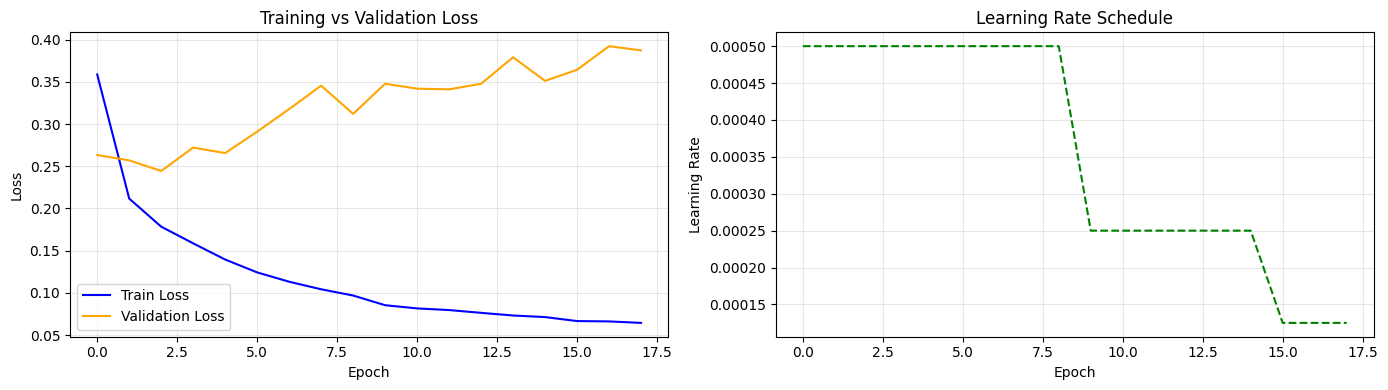

Train Loss: 0.3588 → 0.0644
Val Loss: 0.2634 → 0.3873 (best: 0.2444)


In [ ]:
# Plot training and validation loss
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(train_losses, label='Train Loss', color='blue')
axes[0].plot(val_losses, label='Validation Loss', color='orange')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning Rate
axes[1].plot(lr_history, linestyle='--', color='green', label='Learning Rate')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Train Loss: {train_losses[0]:.4f} → {train_losses[-1]:.4f}")
print(f"Val Loss: {val_losses[0]:.4f} → {val_losses[-1]:.4f} (best: {best_val_loss:.4f})")

In [ ]:
""" Save model
model_dir = os.path.join("..", "models")
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, f"cnn_seq2seq_{TARGET_APPLIANCE}_model.pth")
torch.save({
    'model_state_dict': model.state_dict(),
    'hyperparameters': {
        'hidden_channels': hidden_channels,
        'num_layers': num_layers,
        'window_size': window_size,
        'num_input_features': num_input_features,
        'target_appliance': TARGET_APPLIANCE
    },
    'train_losses': train_losses,
    'val_losses': val_losses,
    'best_val_loss': best_val_loss
}, model_path)
print(f"✓ Model saved: {model_path}")
"""

' Save model\nmodel_dir = os.path.join("..", "models")\nos.makedirs(model_dir, exist_ok=True)\n\nmodel_path = os.path.join(model_dir, f"cnn_seq2seq_{TARGET_APPLIANCE}_model.pth")\ntorch.save({\n    \'model_state_dict\': model.state_dict(),\n    \'hyperparameters\': {\n        \'hidden_channels\': hidden_channels,\n        \'num_layers\': num_layers,\n        \'window_size\': window_size,\n        \'num_input_features\': num_input_features,\n        \'target_appliance\': TARGET_APPLIANCE\n    },\n    \'train_losses\': train_losses,\n    \'val_losses\': val_losses,\n    \'best_val_loss\': best_val_loss\n}, model_path)\nprint(f"✓ Model saved: {model_path}")\n'

## 9. INFERENCE & EVALUATION

In [ ]:
# Evaluation on TEST SET
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

model.eval()
test_idx = 0  # Test sequence to visualize

with torch.no_grad():
    inp = torch.FloatTensor(X_test[test_idx]).unsqueeze(0).to(device)
    pred_power, pred_status = model(inp)
    pred = pred_power.cpu().numpy().squeeze()
    pred_status_prob = torch.sigmoid(pred_status).cpu().numpy().squeeze()
    actual = y_test[test_idx].squeeze()
    actual_status = (actual > ON_THRESHOLD).astype(float)

# Calculate regression metrics
mse = mean_squared_error(actual, pred)
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

# Calculate classification metrics
pred_status_binary = (pred_status_prob > 0.5).astype(float)
status_acc = accuracy_score(actual_status, pred_status_binary)

print(f"📊 TEST Metrics (sequence {test_idx}):")
print(f"  [Regression] MSE: {mse:.6f} | MAE: {mae:.6f} | R²: {r2:.4f}")
print(f"  [Classification ON/OFF] Accuracy: {status_acc:.4f}")

📊 TEST Metrics (sequence 0):
  [Regression] MSE: 0.027285 | MAE: 0.084236 | R²: 0.0000
  [Classification ON/OFF] Accuracy: 1.0000


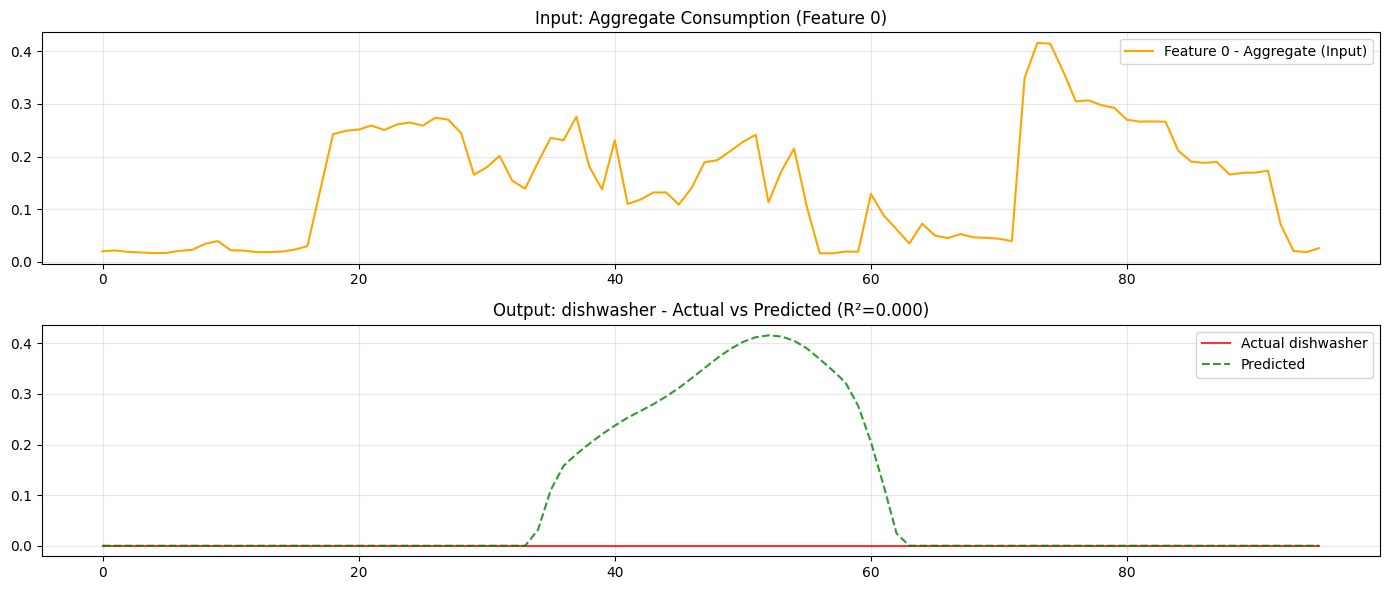

In [ ]:
# Predictions vs actual visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Input - show Feature 0 (assuming it's aggregate)
input_data = X_test[test_idx, :, 0]  # First feature
axes[0].plot(input_data, color='orange', label='Feature 0 - Aggregate (Input)')
axes[0].set_title('Input: Aggregate Consumption (Feature 0)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Output: Prediction vs Actual
axes[1].plot(actual, color='red', label=f'Actual {TARGET_APPLIANCE}', alpha=0.8)
axes[1].plot(pred, color='green', linestyle='--', label='Predicted', alpha=0.8)
axes[1].set_title(f'Output: {TARGET_APPLIANCE} - Actual vs Predicted (R²={r2:.3f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, f1_score
import numpy as np

def evaluate_nilm(y_true, y_pred, threshold=50):
    # Regression
    mae = mean_absolute_error(y_true, y_pred)
    
    # Classification (on/off)
    y_true_bin = (y_true > threshold).astype(int)
    y_pred_bin = (y_pred > threshold).astype(int)
    f1 = f1_score(y_true_bin, y_pred_bin)
    
    return {"MAE": mae, "F1": f1}

Evaluation in progress...

📊 Metrics on ENTIRE TEST SET (5281 sequences):
  Average MSE: 0.016606 ± 0.026813
  Average MAE: 0.031676 ± 0.044028
  Average R²:  0.2228 ± 0.5241
  Sequences with R² < -1 (corrected to 0): 550


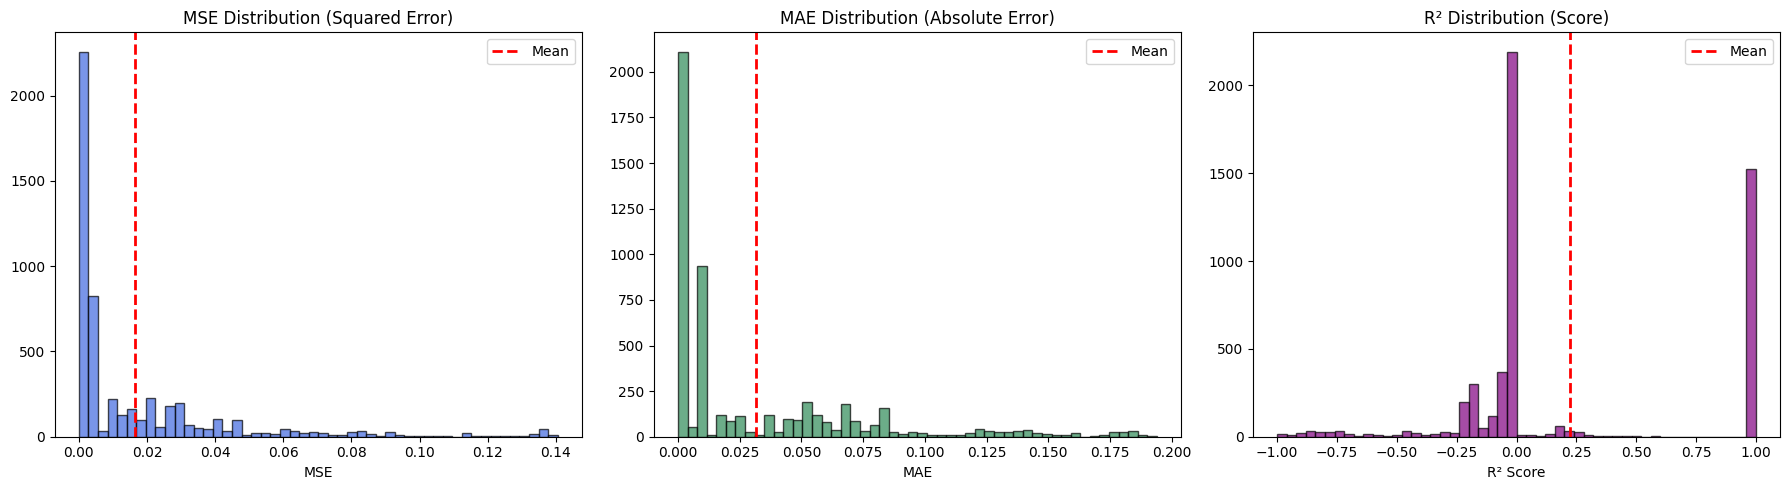

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ===== EVALUATION ON ENTIRE TEST SET =====
metrics = {'mse': [], 'mae': [], 'r2': []}
cnt = 0

# Confidence threshold for considering the appliance on
CONFIDENCE_THRESHOLD = 0.5

model.eval()
print("Evaluation in progress...")

with torch.no_grad():
    for i in range(len(X_test)):
        # Input preparation
        # Assuming X_test is a numpy array (N, Channels, Length)
        inp = torch.FloatTensor(X_test[i]).unsqueeze(0).to(device)
        
        # 1. MODEL NOW RETURNS 2 VALUES
        pred_power_out, pred_status_out = model(inp)
        
        # 2. POST-PROCESSING (The magic part)
        # Convert status logits to probabilities (0 to 1)
        prob_status = torch.sigmoid(pred_status_out)
        
        # Create a mask: 1 if confident it's on, 0 otherwise
        mask = (prob_status > CONFIDENCE_THRESHOLD).float()
        
        # Multiply predicted power by the mask
        # This zeros out predicted consumption when the network thinks it's off
        final_pred_tensor = pred_power_out * mask
        
        # Conversione in numpy per le metriche
        pred = final_pred_tensor.cpu().numpy().squeeze()
        actual = y_test[i].squeeze()
        
        # --- METRICS CALCULATION ---
        
        # Note: If you normalized the data, you should denormalize here
        # to get MSE and MAE in real Watts!
        # e.g.: pred = pred * std_val + mean_val
        
        metrics['mse'].append(mean_squared_error(actual, pred))
        metrics['mae'].append(mean_absolute_error(actual, pred))
        
        # Handle R2
        rscore = r2_score(actual, pred)
        
        # Filters for statistical stability (optional)
        if rscore < -1:
            # Very negative R2 means model worse than average
            rscore = 0.0 
            cnt += 1
        
        metrics['r2'].append(rscore)

# ===== PRINT RESULTS =====
print(f"\n📊 Metrics on ENTIRE TEST SET ({len(X_test)} sequences):")
print(f"  Average MSE: {np.mean(metrics['mse']):.6f} ± {np.std(metrics['mse']):.6f}")
print(f"  Average MAE: {np.mean(metrics['mae']):.6f} ± {np.std(metrics['mae']):.6f}")
print(f"  Average R²:  {np.mean(metrics['r2']):.4f} ± {np.std(metrics['r2']):.4f}")
print(f"  Sequences with R² < -1 (corrected to 0): {cnt}")

# ===== VISUALIZATION =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram MSE
axes[0].hist(metrics['mse'], bins=50, color='royalblue', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(metrics['mse']), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].set_title('MSE Distribution (Squared Error)')
axes[0].set_xlabel('MSE')
axes[0].legend()

# Histogram MAE
axes[1].hist(metrics['mae'], bins=50, color='seagreen', alpha=0.7, edgecolor='black')
axes[1].axvline(np.mean(metrics['mae']), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].set_title('MAE Distribution (Absolute Error)')
axes[1].set_xlabel('MAE')
axes[1].legend()

# Histogram R2
axes[2].hist(metrics['r2'], bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[2].axvline(np.mean(metrics['r2']), color='red', linestyle='--', linewidth=2, label='Mean')
axes[2].set_title('R² Distribution (Score)')
axes[2].set_xlabel('R² Score')
axes[2].legend()

plt.tight_layout()
plt.show()


🔴 Top 3 WORST predictions:
  1. Sample 3982: R²=-0.4130, MAE=0.0954
  2. Sample 3987: R²=-0.4129, MAE=0.0959
  3. Sample 3983: R²=-0.4129, MAE=0.0959

🟢 Top 3 BEST predictions:
  1. Sample 15: R²=1.0000, MAE=0.0000
  2. Sample 0: R²=1.0000, MAE=0.0000
  3. Sample 2834: R²=1.0000, MAE=0.0000


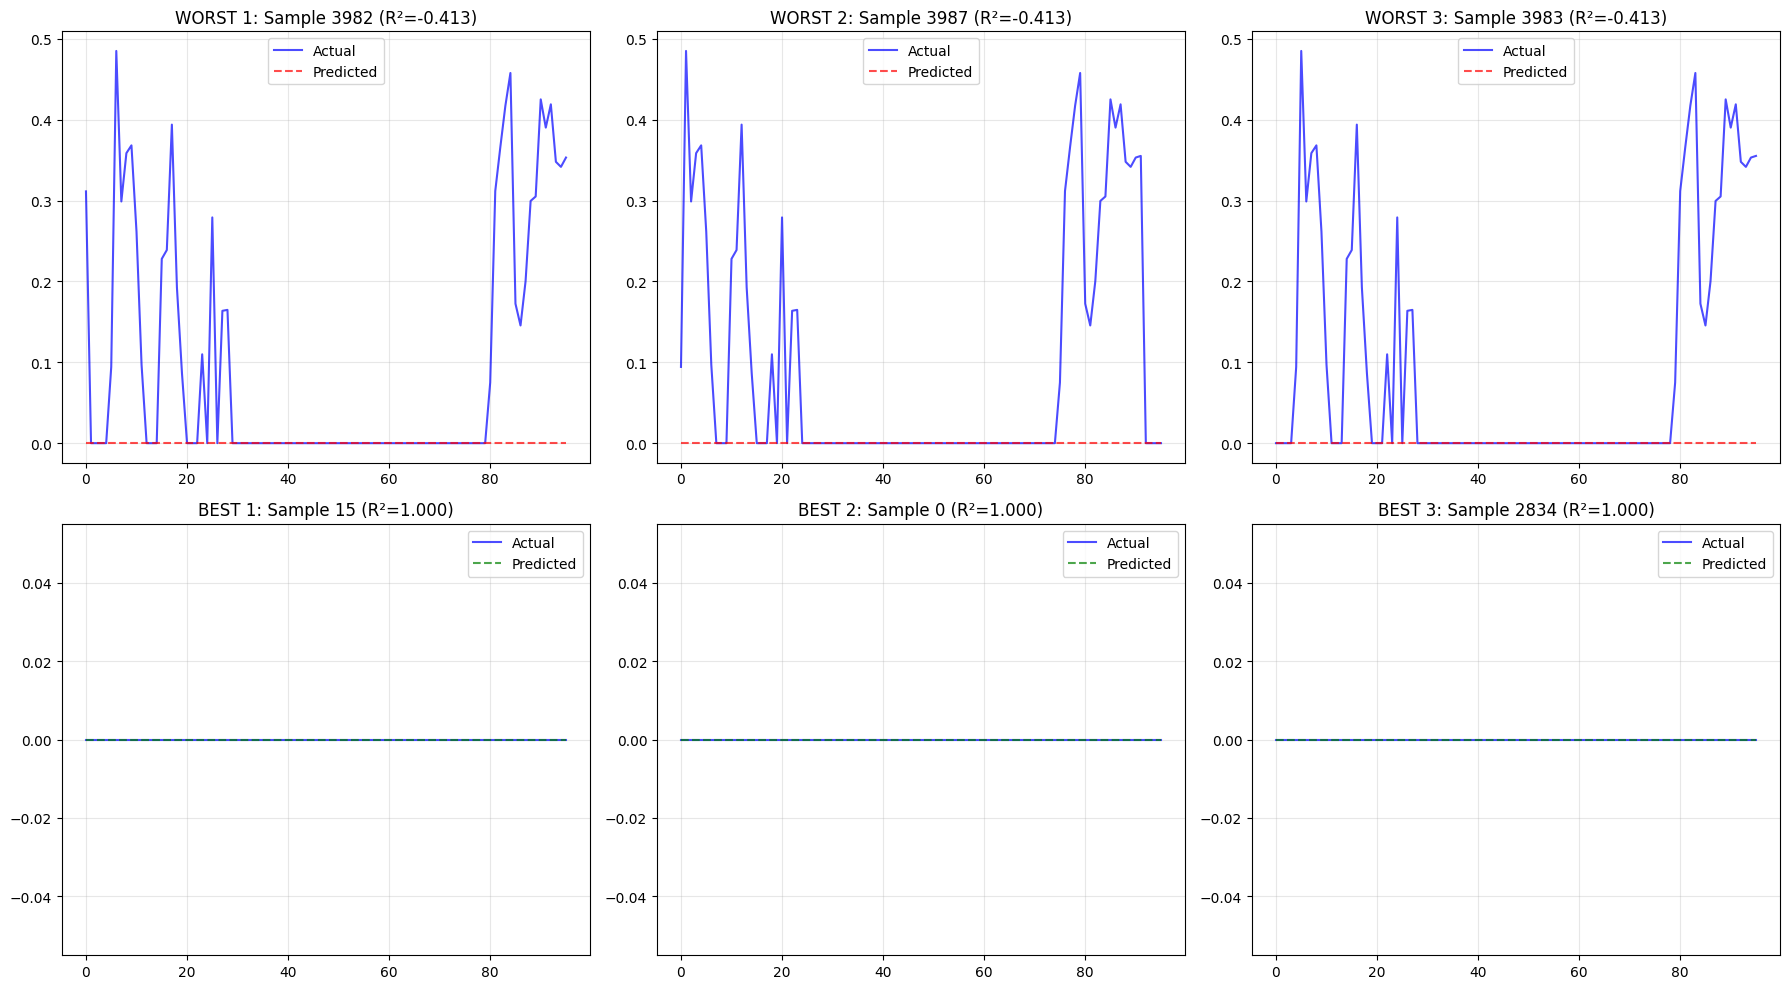

In [ ]:
# ===== BEST VS WORST PREDICTIONS VISUALIZATION =====
# Find the 3 worst and 3 best predictions

# Sort by R²
sorted_indices = np.argsort(metrics['r2'])
worst_3_idx = sorted_indices[:3]  # Lowest R²
best_3_idx = sorted_indices[-3:][::-1]  # Highest R²

print("\n🔴 Top 3 WORST predictions:")
for rank, idx in enumerate(worst_3_idx, 1):
    print(f"  {rank}. Sample {idx}: R²={metrics['r2'][idx]:.4f}, MAE={metrics['mae'][idx]:.4f}")

print("\n🟢 Top 3 BEST predictions:")
for rank, idx in enumerate(best_3_idx, 1):
    print(f"  {rank}. Sample {idx}: R²={metrics['r2'][idx]:.4f}, MAE={metrics['mae'][idx]:.4f}")

# Plot comparison best vs worst
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, idx in enumerate(worst_3_idx):
    with torch.no_grad():
        inp = torch.FloatTensor(X_test[idx]).unsqueeze(0).to(device)
        pred_power_out, pred_status_out = model(inp)
        prob_status = torch.sigmoid(pred_status_out)
        mask = (prob_status > CONFIDENCE_THRESHOLD).float()
        pred = (pred_power_out * mask).cpu().numpy().squeeze()
        actual = y_test[idx].squeeze()
    
    axes[0, i].plot(actual, label='Actual', color='blue', alpha=0.7)
    axes[0, i].plot(pred, label='Predicted', color='red', linestyle='--', alpha=0.7)
    axes[0, i].set_title(f'WORST {i+1}: Sample {idx} (R²={metrics["r2"][idx]:.3f})')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)

for i, idx in enumerate(best_3_idx):
    with torch.no_grad():
        inp = torch.FloatTensor(X_test[idx]).unsqueeze(0).to(device)
        pred_power_out, pred_status_out = model(inp)
        prob_status = torch.sigmoid(pred_status_out)
        mask = (prob_status > CONFIDENCE_THRESHOLD).float()
        pred = (pred_power_out * mask).cpu().numpy().squeeze()
        actual = y_test[idx].squeeze()
    
    axes[1, i].plot(actual, label='Actual', color='blue', alpha=0.7)
    axes[1, i].plot(pred, label='Predicted', color='green', linestyle='--', alpha=0.7)
    axes[1, i].set_title(f'BEST {i+1}: Sample {idx} (R²={metrics["r2"][idx]:.3f})')
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 📊 Comparative Evaluation: Train vs Val vs Test

In [ ]:
# ===== EVALUATION ON ALL 3 SETS =====
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import torch

def evaluate_dataset(model, X, y, device, dataset_name="Dataset"):
    """Evaluate model on a dataset and return aggregated metrics"""
    model.eval()
    
    all_preds = []
    all_actuals = []
    
    with torch.no_grad():
        for i in range(len(X)):
            inp = torch.FloatTensor(X[i]).unsqueeze(0).to(device)
            pred_power_out, pred_status_out = model(inp)
            
            # Post-processing con confidence threshold
            prob_status = torch.sigmoid(pred_status_out)
            mask = (prob_status > CONFIDENCE_THRESHOLD).float()
            pred = (pred_power_out * mask).cpu().numpy().squeeze()
            
            all_preds.append(pred)
            all_actuals.append(y[i].squeeze())
    
    all_preds = np.array(all_preds).flatten()
    all_actuals = np.array(all_actuals).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(all_actuals, all_preds)
    mae = mean_absolute_error(all_actuals, all_preds)
    r2 = r2_score(all_actuals, all_preds)
    
    return {
        'dataset': dataset_name,
        'samples': len(X),
        'mse': mse,
        'mae': mae,
        'r2': r2
    }

# Evaluate on all 3 sets
print("🔄 Evaluation in progress on Train, Validation and Test set...\n")

train_metrics = evaluate_dataset(model, X_train, y_train, device, "TRAIN")
val_metrics = evaluate_dataset(model, X_val, y_val, device, "VALIDATION")
test_metrics = evaluate_dataset(model, X_test, y_test, device, "TEST")

# Print comparison table
print("=" * 80)
print(f"{'Dataset':<15} {'Samples':>10} {'MSE':>15} {'MAE':>15} {'R²':>12}")
print("=" * 80)
for m in [train_metrics, val_metrics, test_metrics]:
    print(f"{m['dataset']:<15} {m['samples']:>10,} {m['mse']:>15.6f} {m['mae']:>15.6f} {m['r2']:>12.4f}")
print("=" * 80)

# Calculate overfitting gap
train_test_gap = train_metrics['r2'] - test_metrics['r2']
val_test_gap = val_metrics['r2'] - test_metrics['r2']

print(f"\n📈 Overfitting Analysis:")
print(f"  Train-Test R² Gap: {train_test_gap:+.4f} {'⚠️ OVERFITTING' if train_test_gap > 0.1 else '✅ OK'}")
print(f"  Val-Test R² Gap:   {val_test_gap:+.4f} {'⚠️ LEAKAGE' if abs(val_test_gap) > 0.05 else '✅ OK'}")

🔄 Evaluation in progress on Train, Validation and Test set...

Dataset            Samples             MSE             MAE           R²
TRAIN               24,097        0.006266        0.013873       0.1224
VALIDATION           5,377        0.010746        0.022741       0.0745
TEST                 5,281        0.007980        0.018964       0.0440

📈 Overfitting Analysis:
  Train-Test R² Gap: +0.0784 ✅ OK
  Val-Test R² Gap:   +0.0305 ✅ OK


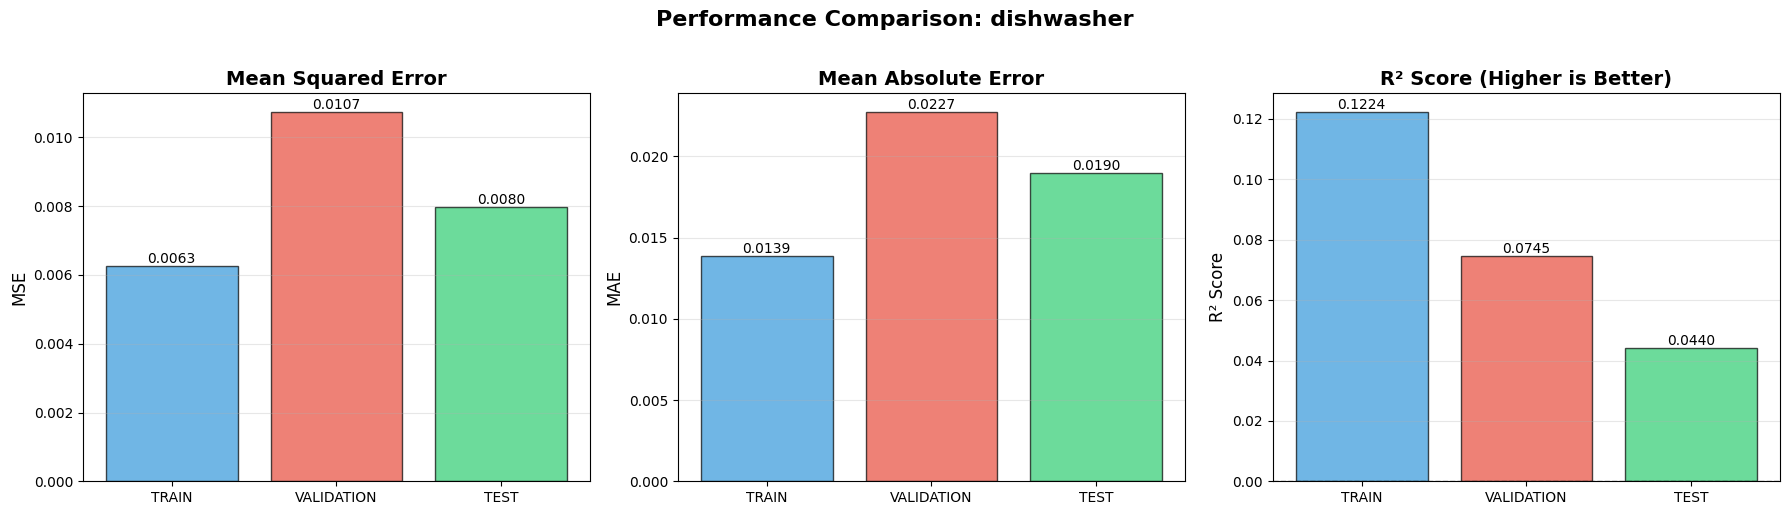


💡 Interpretation:
  ⚠️ Slight overfitting - Train better than Test
  🚨 Very low performance - review approach


In [ ]:
# ===== COMPARATIVE VISUALIZATION =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets_metrics = [train_metrics, val_metrics, test_metrics]
colors = ['#3498db', '#e74c3c', '#2ecc71']
dataset_names = ['TRAIN', 'VALIDATION', 'TEST']

# Plot 1: MSE Comparison
mse_values = [m['mse'] for m in datasets_metrics]
bars1 = axes[0].bar(dataset_names, mse_values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('MSE', fontsize=12)
axes[0].set_title('Mean Squared Error', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars1, mse_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# Plot 2: MAE Comparison
mae_values = [m['mae'] for m in datasets_metrics]
bars2 = axes[1].bar(dataset_names, mae_values, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars2, mae_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# Plot 3: R² Comparison
r2_values = [m['r2'] for m in datasets_metrics]
bars3 = axes[2].bar(dataset_names, r2_values, color=colors, alpha=0.7, edgecolor='black')
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].set_title('R² Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[2].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars3, r2_values):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'{val:.4f}', ha='center', va='bottom' if val > 0 else 'top', fontsize=10)

plt.suptitle(f'Performance Comparison: {TARGET_APPLIANCE}', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Results interpretation
print("\n💡 Interpretation:")
if train_test_gap < 0.05:
    print("  ✅ Model generalizes well - Train and Test similar")
elif train_test_gap < 0.15:
    print("  ⚠️ Slight overfitting - Train better than Test")
else:
    print("  🚨 Significant overfitting - Increase regularization!")

if test_metrics['r2'] > 0.7:
    print("  🎯 Excellent performance on test set!")
elif test_metrics['r2'] > 0.5:
    print("  📊 Acceptable performance on test set")
elif test_metrics['r2'] > 0.3:
    print("  ⚠️ Low performance - consider architecture improvements")
else:
    print("  🚨 Very low performance - review approach")